# RNN -> LSTM

# Looking 1 year ahead with 1 year of patient observation

### 2 patient observation time = 1 year of patient observation
### 8 features = 3 fixed features + 5 timed features
### 16 input length = (8 features * 2 patient observation time) 
### 5 training timesteps x => y
### Evaluated by MSE 

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import sklearn as sk
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

/Users/matiasberretta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def select_columns(col_list, n_months):
    
    """takes in a list of column names and number of visits starting at 0
    returns column list time-stepped and dovetailed""" 
    
    return dovetail_names(*[time_step_names(i, n_months) for i in col_list])
        
def time_step_names(name, n_months):

    return [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6)]

def dovetail_names(*kwargs):
    zipped = zip(*kwargs)
    l = []
    for i in zipped:
        for j in i:
            l.append(j)
    return l

def stretch_input(Xtr, pot):

    """Xtr_fill is empty 3D numpy array where we extend length of patient observation times t
    pot stands for Patient Observation Time. We only need to do this for our X input"""
    
    Xtr_fill = np.zeros(shape=[Xtr.shape[0],time_steps,8*pot] , dtype = object) 
    
    for subject in range(Xtr.shape[0]):

        for i in range(time_steps):

            Xtr_fill[subject][i] = np.concatenate([Xtr[subject][i],Xtr[subject][i+1]])
            
    return Xtr_fill

# Filter Data

X_0_2 => y_4

X_1_3 => y_5

X_2_4 => y_6

X_3_5 => y_7

X_4_6 => y_8

X_5_7 => y_9

In [7]:
dataset = pd.read_csv("df_by_subject_11-6.csv", index_col = 0)

# timed featuers
col_names_raw = ['ATTACK','PYRAMIDAL_FUNCTION','CEREBELLAR_FUNCTION','BRAINSTEM_FUNCTION','EDSS']
len_timed_features = len(col_names_raw)
n = 9 # y_9 // number of timesteps after 0 => t8 is equal to 4 years 
time_col_names = select_columns(col_names_raw, n)

# fixed features
fixed_col_names = ['DOB_YEAR','SEX','RACE']
len_fixed_features = len(fixed_col_names)

# timed features + fixed features 
all_col_names = fixed_col_names.copy()
all_col_names.extend(time_col_names)

col_names_together = ['DOB_YEAR','SEX','RACE','ATTACK','PYRAMIDAL_FUNCTION','CEREBELLAR_FUNCTION','BRAINSTEM_FUNCTION','EDSS']
n_features = len(col_names_together) 
col_names_together_timed = select_columns(col_names_together, n)
len_all_col_names = len(col_names_together_timed)

### "Fixed" Data Set for fixed values such as sex, race, etc

In [8]:
df_fixed = dataset[fixed_col_names].copy()
#========================#========================#========================#========================
df_fixed['SEX'] = pd.get_dummies(df_fixed['SEX']).iloc[:,1]

df_fixed['RACE'].replace(['E','S'],0, inplace=True)

In [9]:
m_dataset = dataset.copy()

for initial_name in fixed_col_names:
    for col_name in select_columns([initial_name], n):
        m_dataset[col_name] = df_fixed[initial_name]

# Fill in Missing Values

In [10]:
df = m_dataset[col_names_together_timed].copy()

"""CONTINUOUS"""
# Z-score mask EDSS
for col in select_columns(['EDSS'],n): # drop edss_30
    df.loc[: ,col].fillna(df.loc[: ,col].dropna().mode()[0], inplace=True)

"""BINARY CATEGORICAL"""
# Replace Q and N as NaN, Nan with mode
for col in select_columns(['ATTACK'],n):
    df.loc[: ,col].replace(['Q','N'], np.NaN, inplace=True)
    df.loc[: ,col].fillna(0, inplace=True)

"""MULTICLASS CATEGORICAL"""
# Replace X with NaN, NaNs with mode
for col in select_columns(['CEREBELLAR_FUNCTION'],n):
    df.loc[: ,col].replace('X', np.NaN, inplace=True) 
    df.loc[: ,col].fillna(0, inplace=True)
    
# Replace NaNs with mode
for col in select_columns(['PYRAMIDAL_FUNCTION'],n):
    df.loc[: ,col].fillna(0, inplace=True)
    
# Replace X with NaN, NaNs with mode
for col in select_columns(['BRAINSTEM_FUNCTION'],n):
    df.loc[: ,col].replace('X', np.NaN, inplace=True) 
    df.loc[: ,col].fillna(0, inplace=True)
    

# Reshaping Data into RNN friendly shape

In [13]:
X = df.iloc[:,:len_all_col_names-n_features].copy() # up to t7 (_42)
# X goes up to the length of the total available dataframe columns - t amount of length of column list for a timestep
#y = df.loc[:, select_columns(['EDSS'], n)].iloc[:15,1:].values
y = df[select_columns(['EDSS'], n)].drop(select_columns(['EDSS'], n-5), axis = 1) # from t3 to t8 (_24-_48)
print(X.shape, y.shape) 

(508, 72) (508, 5)


# Split into train and test

In [14]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.20, random_state=1)

# Reshape train and test into rnn friendly 3D arrays

In [16]:
time_steps = 5 # number of time steps that will be taken in RNN 

In [17]:
X_train_r = X_train_df.values.reshape(-1, n, n_features) # n will be turned to time_steps for X_train
y_train = y_train_df.values.reshape(-1, time_steps, 1)
print("X reshaped is " + str(X_train_r.shape))
print("y reshaped is " + str(y_train.shape))

X reshaped is (406, 9, 8)
y reshaped is (406, 5, 1)


In [18]:
X_test_r = X_test_df.values.reshape(-1, n, n_features) # n will be turned to time_steps for X_train
y_test = y_test_df.values.reshape(-1, time_steps, 1)
print("X reshaped is " + str(X_test_r.shape))
print("y reshaped is " + str(y_test.shape))

X reshaped is (102, 9, 8)
y reshaped is (102, 5, 1)


### Extend Patient Observation (Only for X)

In [19]:
pot = 2 # length of X's timewindow in t

X_train = stretch_input(X_train_r, pot) # X_train will be shaped [406, 5, 16] derived from X_train_r's [406, 8, 8]
X_test = stretch_input(X_test_r, pot)

# RNN parameters

In [20]:
# 27 features + 38 fixed features 

n_inputs = 8*pot # 8 features times 2 timesteps of patient observation

n_neurons = 15

n_layers = 1

n_outputs = 1

learning_rate = 0.001

n_steps = 5 # 5 steps 

In [21]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name = "X") # [None, 8, 27]
y = tf.placeholder(tf.int32, [None, n_steps, 1], name = "y") # changed from tf.float32 to tf.int32 

In [22]:
layers = [tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation = tf.nn.relu)for layer in range(n_layers)]

lstm_cell = tf.contrib.rnn.LSTMCell(num_units = n_neurons, use_peepholes = True)
output_seqs, (c_states, h_states) = tf.nn.dynamic_rnn(lstm_cell, X, dtype = tf.float32)

predictions = tf.contrib.layers.fully_connected(output_seqs, 1, activation_fn=tf.sigmoid)

loss = tf.losses.mean_squared_error(labels = y, predictions = predictions)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(loss)

In [23]:
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

In [24]:
n_epochs = 20
batch_sz = 50
mse_train = []
mse_test = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iter in range(len(X_train) // batch_sz):

            X_batch, y_batch = X_train[iter*batch_sz: (iter+1)*batch_sz], y_train[iter*batch_sz: (iter+1)*batch_sz]
            X_batch = X_batch.reshape((-1, n_steps, 16))
            y_batch = y_batch.reshape((-1, n_steps, 1)) # added 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        mse_train.append(sess.run(loss, feed_dict={X: X_batch, y: y_batch}))
        
        mse_test.append(sess.run(loss, feed_dict={X : X_test.reshape((-1, n_steps, n_inputs)), 
                                              y : y_test.reshape((-1,n_steps,1))}))

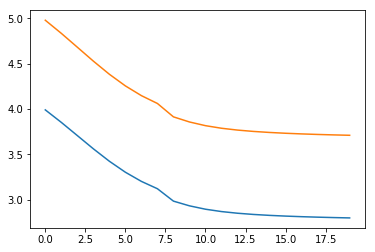

In [25]:
plt.plot(mse_train)
plt.plot(mse_test)

In [26]:
print("Train MSE:", mse_train[-1], "Test MSE:", mse_test[-1])

Train MSE: 2.8003142 Test MSE: 3.7107844
